# Experiments FSS DCF

This notebook contain the experiments on the private Distributed Comparison Function 

## P-Party DCF

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# fss lib
from pysrc.utils import *
from pysrc.DistributedComparisonFunctionForPParties import DistributedComparisonFunctionForPParties
from pysrc.simulation_structures import *

# utils
from joblib import Parallel, delayed
from time import time

### Synthetic datasets :

The functions in the following section are used to create/manipulate the input data of data owners

In [2]:
from scipy.stats import poisson, norm, multinomial

In [3]:
def generate_synthetic_data(
    distribution : object,
    distribution_params : dict,
    size : int
    ):
    """
    Generate synthetic data with scipy.stat distribution objects
    """
    return distribution.rvs(size = size, **distribution_params)

def discretize(data,domain,number_bins):
    """
    Create the bins for the input precision and use the numpy function digitize on the data and the created bins.
    
    params :
        data (numpy.array) The data to discretize
        precision : Number of decimals to keep
        
    return :
        tuple of size 2, the bins, and the return of np.digitize(data,bins)
    """
    # Avoir un tuple range ex: (0,100) découpé en un nombre de bins
    # Domaine F --> transforme en bins
    alpha = (domain[1] - domain[0]) / number_bins
    bins = np.array([domain[0] + alpha * i for i in range(number_bins)])
    #bins = np.array([10 ** -precision * i for i in range(1,int(max(data) * 10 ** precision) + 1)])
    return bins, np.digitize(data,bins,right = True)

def parse_results(
    data : np.array,
    bins : np.array,
    method : str
):
    """
    Parse the results from the input data, wich is assumed to correspond to the binned representation of the data with bins
    
    return : (np.array) An approximation of the results in the default representation
    """
    if method == 'mean' : # Moyenne entre bin[i] et bin[-1] ; attention aux 0
        return (bins[data] + bins[data - 1]) / 2
    if method == 'sup' : # bin[i]
        return bins[data]

### Real datasets

(Not implemented)

### Experiments :

The experiments are implemented with the following scheme :

* Generation of the data with the previous functions
* Run the 'experiment' function below
* Plotting/outputting the desired results

In [4]:
def experiment(p : int,
               do : int ,
               N : int,
               q : int,
               l : int,
               data : np.array,
               thresholds : np.array,
               verbose : bool = False) -> np.array :
    """
    Experiment the distributed comparison function secret sharing scheme.
    Run the experiments using the fss parameters and the data to share into the data owners.
    
    The experiment use parallel computing with default parameter 'n_jobs' set to -1.
    
    The experiment follow the following scheme :
        
        * Creation of the differents parties (data owners, and servers)
        * Generation of the key by the data owners, wich are sent to the different servers
        * Evaluation of their own shares by the servers
        * Summing of the shares, summing all keys and then output the results as a dict
    
    params :
        p : (int) Number of servers wich compute the comparison function
        do : (int) Number of data owners wich generate the function's shares
        N : (int) Domain of the function (number of values in the dataset)
        q : (int) Domain of G, the output of the comparison function
        l : (int) Lambda, the security parameter in number of bits
        data : (numpy.array) The data to share between data owner
        thresholds : (numpy.array) Values to compare the domain with
        
    return : 
     (dict) : A python dictionary with 4 entries :
        'output' : The output array of the function
        'time' : The compute time of the entire function
        'key_size' : The size of the keys serialized
        'key_size_deserialized' : The size of the keys deserialized
         
    """

    def compute_every_key(fss,server,nb_keys,N):
        """
        Make the server evaluate all his key with the given fss instance
        Made for parallel computing.
        """
        res = np.zeros((nb_keys,N))
        for k in range(nb_keys):
            res[k] = server.evaluate(fss,k) # implement the mapping function here, see if N need to be updated, I think N here refers to the number of thresholds instead of the domain size
        return res
        
    servers = []
    data_owners = []

    # instantiation of the FSS DCF scheme
    fss = DistributedComparisonFunctionForPParties(p = p, N = N, q = q, lambd = l)
    ti = time()

    data_shares = np.array_split(data,do)
    
    
    # Creation of the servers
    for _ in range(p):
        servers.append(Server())

    # Creation of the data owners
    for i in range(do):
        data_owners.append(DataOwner(data_shares[i],N=N, bins=thresholds))

    # Generation of keys and sending to the servers

    for i in range(do):
        for keys in data_owners[i].generate(fss) :
            for k in range(p) :
                servers[k].receive(keys[k])

    nb_keys = servers[0].count
        
    # Servers evaluate all of the function's shares on the domain, sums the result and output it (maybe applicate differential privacy)
    
    res_list = Parallel(n_jobs=-1)(
        delayed(compute_every_key)(fss,servers[i],nb_keys,N) for i in range(p)
    )
    
    # Servers sums their results to compute f(x_i)
    
    outputs = res_list[0]
    for res in res_list[1:] :
        outputs = (outputs + res) % q
    
    # Summing the results for each x_i in X
    
    output = np.sum(outputs,axis = 0)
    
    tf = time()
    key_size = len(servers[0].keys[0])
    key_size_deserialize = len(deserialize(servers[0].keys[0]))
    
    results = {
        'output' : output,
        'time' : tf - ti,
        'key_size' : key_size ,
        'key_size_deserialized' : key_size_deserialize ,
              }
    
    if verbose :
        print('key size :',key_size,'key size deserialized :',key_size_deserialize)
        print('Running time : ',tf - ti,' seconds')
    
    return results

### Results

The result of the preceding experiment is defined as a python dictionnary like this :

* An index 'output' wich contain the results of the function secret shared in a numpy array
* The index 'time' wich contain the total execution time
* 'key_size', the length of serialized key
* 'key_size_deserialized', the length of deserialized key.

2 types of plots are needed :
* The ECDF curve
* The histogram of the values

TO DO :
* evaluation metrics

The following functions are defined below

In [5]:
def plot_ecdf(results,N,bins = None, ax = None, full_domain = False):
    """
    Plot the Empirical Cumulative Distribution Function from the results of the experiments
    If the parameter 'full_domain' is set to True, plot the ecdf on the entire domain, if False
    set plot the ecdf only on the non-constant part of the function
    
    Params :
        results (np.array) : results array from the experiment
        N (int) : Domain of the function studied
        full_domain (boolean) : If set to True, plot the entire domain
    
    """
    if not ax :
        fig, ax = plt.subplots(1,1)
        
    if type(bins) != np.ndarray :
        bins = np.arange(N)
        
    nb_values = np.max(results)
    first_arg = np.argmax(results != 0)
    last_arg = np.argmax(results == nb_values)
    
    ax.plot(bins, results / nb_values)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    
    if not full_domain :
        ax.set(xlim=(bins[first_arg],bins[last_arg]))
        ax.set_title('ECDF on specific values')
    else :
        ax.set_title('ECDF on the complete domain')  
        
    plt.draw()
    
def plot_histogram(results,N,bins = None, ax = None, full_domain = False):
    """
    Plot the Empirical Cumulative Distribution Function from the results of the experiments
    If the parameter 'full_domain' is set to True, plot the ecdf on the entire domain, if False
    set plot the ecdf only on the non-constant part of the function
    
    Params :
        results (np.array) : results array from the experiment
        N (int) : Domain of the function studied
        full_domain (boolean) : If set to True, plot the entire domain
    
    """
    if not ax :
        fig, ax = plt.subplots(1,1)
        
    if type(bins) != np.ndarray :
        bins = np.arange(N)
        
    hist = (results - np.hstack(([0],results))[:-1])
    
    first_nzero = np.argmax(hist != 0)
    last_nzero = results.size - np.argmax(np.flip(hist) != 0)
    
    ax.bar(bins,hist)
    ax.set_xlabel('x')
    ax.set_ylabel('Number of occurences of x')
    
    if not full_domain :
        ax.set_title('Histogram of the non zeros values')
        ax.set(xlim=(max(bins[first_nzero] - 1,0), bins[last_nzero]))
    else :
        ax.set_title('Histogram of the complete domain')

    plt.draw()

def plot_histograms_and_ecdf(results, N,bins = None, save_path : str = None):
    """
    Plot the Empirical Cumulative Distribution Function from the results of the experiments
    If the parameter 'full_domain' is set to True, plot the ecdf on the entire domain, if False
    set plot the ecdf only on the non-constant part of the function
    
    Params :
        results (np.array) : results array from the experiment
        N (int) : Domain of the function studied
        full_domain (boolean) : If set to True, plot the entire domain
    
    """
    plots = [plot_ecdf,plot_histogram,plot_ecdf,plot_histogram]
    params = [False,False,True,True]

    fig, axes = plt.subplots(2,2,figsize = (15,10))

    for ind, ax in enumerate(axes.flatten()):
        plots[ind](results= results, N = N,bins = bins, ax = ax, full_domain = params[ind])
        
    if save_path :
        plt.savefig(save_path)
    
    fig.suptitle(f'Results for the function domain [0,{N}]')
    plt.draw()

### Experiments :

#### Continuous data without discretization :

The data is casted by default to int before generation. Thus, the continuous data is rounded to the previous integer.

In [6]:
# FSS params :
p = 3
do = 4
q = 2
l = 10
N = 1000
size = 2 ** 14

In [157]:
# To run the experiment we need data
data = generate_synthetic_data(norm,{'loc' : 500,'scale':100}, size = size)

# And then just run the experiment with thoses parameters
results = experiment(p = p,do = do, N = N , q = q, l = l, data = data)

# We can output only the results we are needing
# plot_histograms_and_ecdf(results['output'], N)

In [16]:
def ecdf(data, N):
    ecdf_results = []
    for i in np.linspace(data.min(), data.max(), N):
        ecdf_results.append(len(data[data <= i]))
    return np.array(ecdf_results)

In [ ]:
ecdf_true = ecdf(data, N)

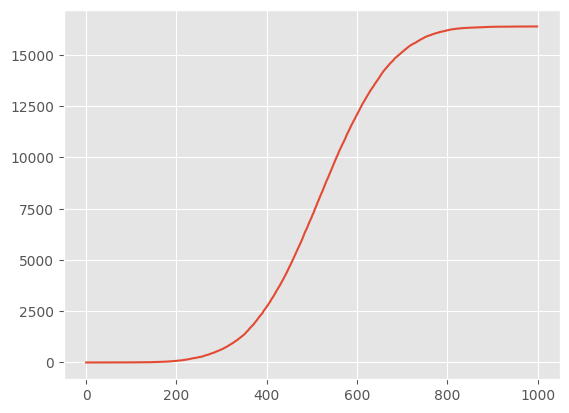

In [159]:
plt.plot(np.arange(N), ecdf_true)

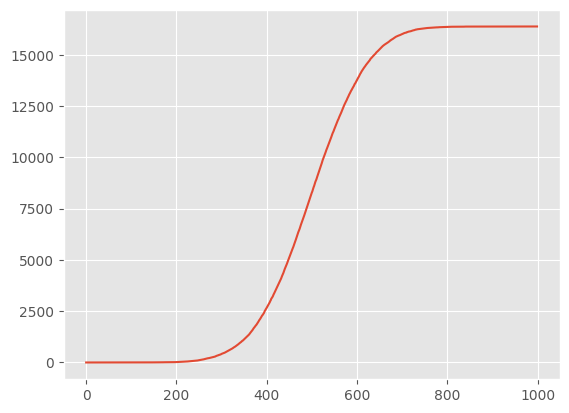

In [160]:
plt.plot(np.arange(N), results['output'])

In [161]:
geo_score(np.arange(N), ecdf_true, np.arange(N), results['output'])

393975.0

#### Continuous data with discretization

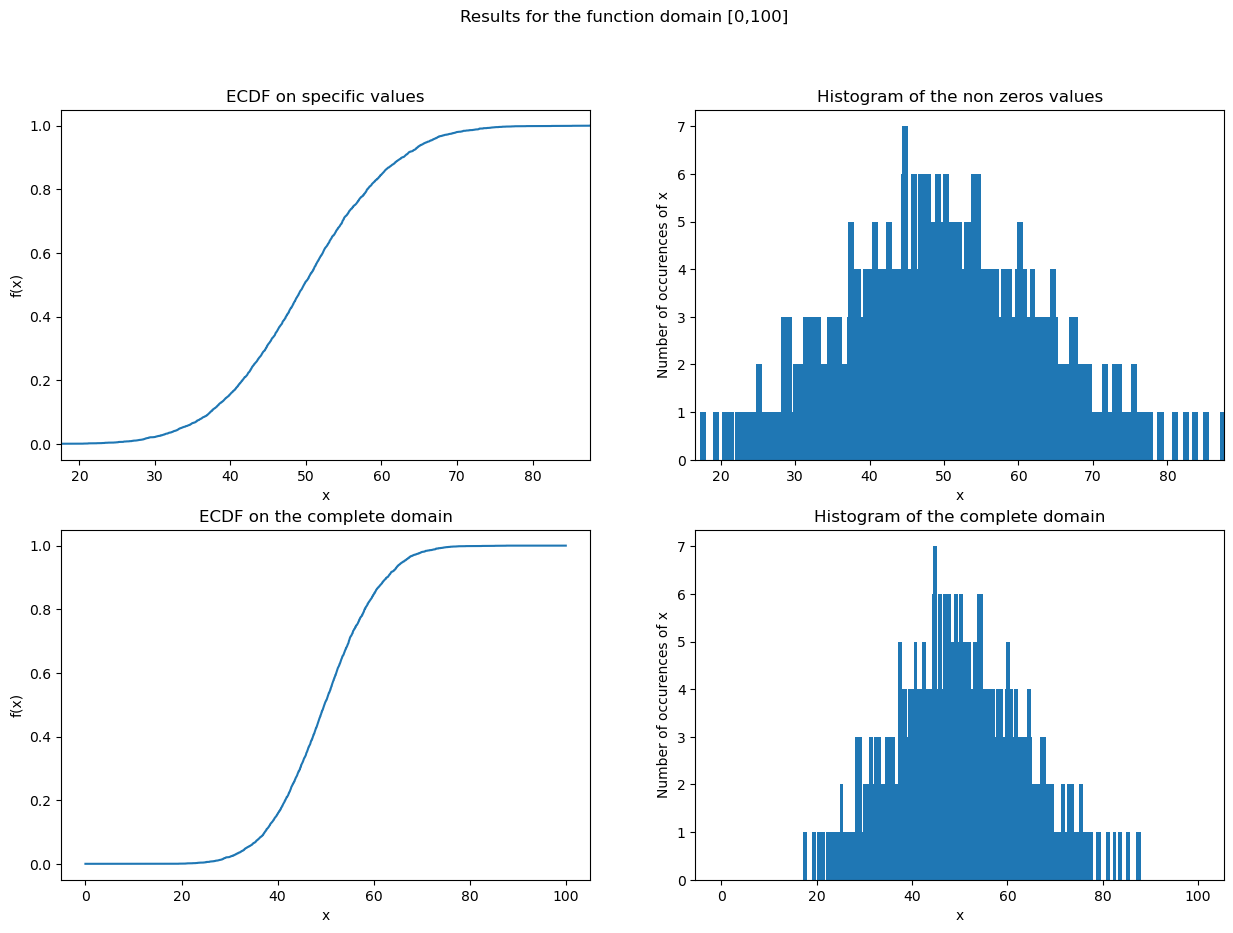

In [7]:
# Parameters
p = 3
do = 4
q = 2
l = 10
size = 2 ** 12
N = 100
# Creating the data
data = generate_synthetic_data(norm,{'loc' : 50,'scale':10}, size = size)

# Creating bins to discretize the data
bins, data_discretized = discretize(data,domain = (0,N),number_bins= N * 100)

# We need to extend the FSS domain to the number of bins, all other parameters still the same
new_N = bins.shape[0]

# Run experimentations
results = experiment(p = p,do = do, N = new_N , q = q, l = l, data = data_discretized)

# output results
plot_histograms_and_ecdf(results['output'],N = N,bins = bins)

### Experiment with real world data

In [6]:
datadir = '../../data'
dataset_name = 'framingham'
df_fram = pd.read_csv(f'{datadir}/{dataset_name}.csv').fillna(0)
X = df_fram[[col for col in df_fram.columns if col != 'TenYearCHD']]
y = df_fram.TenYearCHD

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                             random_state=42)

classif = LogisticRegression(solver='lbfgs')
classif = make_pipeline(StandardScaler(with_mean=False),
                                classif)
classif.fit(X_train, y_train)
y_pred = classif.decision_function(X_test)

In [8]:
np.max(y_pred) + y_pred.min()

-1.4194040779783776

In [32]:
y_pred_shift = (y_pred + abs(y_pred.min())) * (N / (y_pred + abs(y_pred.min())).max())

In [9]:
def transform_eval_input(data, N):
    if data.min() < 0:
        data = data - data.min()
    return data * N / data.max()

def get_distributed_roc(p, do, N, q, l, data, ground_truth, precision, pos_label=1):
    data_t = data[ground_truth == pos_label]
    data_f = data[ground_truth != pos_label]
    
    data_t_input = transform_eval_input(data_t, precision)
    data_f_input = transform_eval_input(data_f, precision)

    thresholds = np.linspace(0, precision, N)
    
    data_t_results = experiment(p = p,do = do, N = N , q = q, l = l, data = data_t_input, thresholds=thresholds)
    data_f_results = experiment(p = p,do = do, N = N , q = q, l = l, data = data_f_input, thresholds=thresholds)
    
    tpr = data_t_results['output'] / data_t_results['output'].max()
    fpr = data_f_results['output'] / data_f_results['output'].max()
    
    tpr = np.r_[0, tpr, 1]
    fpr = np.r_[0, fpr, 1]

    return fpr, tpr

def auc(x: np.array,
        y: np.array):
    """
    Compute Area Under the Curve (AUC) using the trapezoidal rule.

    :param x : ndarray of shape (n,)
        x coordinates. These must be either monotonic increasing or monotonic
        decreasing.
    :param y : ndarray of shape, (n,)
        y coordinates.

    :return: float auc:
    """
    area = np.trapz(y, x)
    return area

def plot_roc(fpr, tpr):
    roc_auc = auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.style.use('ggplot')

    fig, ax = plt.subplots()

    label = f"(AUC = {roc_auc:0.2f})"

    xlabel = "False Positive Rate"
    ylabel = "True Positive Rate"
    ax.set(xlabel=xlabel, ylabel=ylabel)

    ax.legend(loc="lower right")

    ax.plot(fpr, tpr, label=label)
    plt.show()

In [10]:
# FSS params :
p = 3
do = 4
q = 2
l = 10
precision = 100000
N = 100

In [12]:
fpr, tpr = get_distributed_roc(p, do, N, q, l, y_pred, y_test, precision)

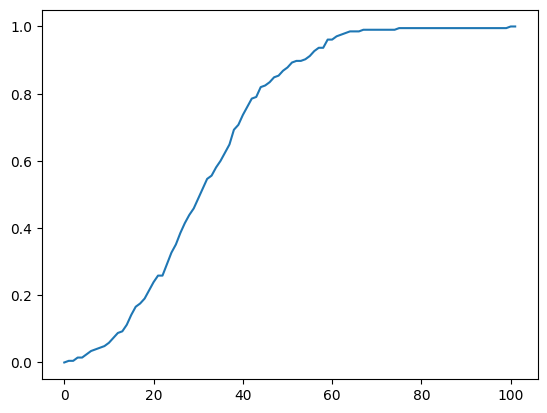

In [13]:
plt.plot(np.arange(N+2), tpr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


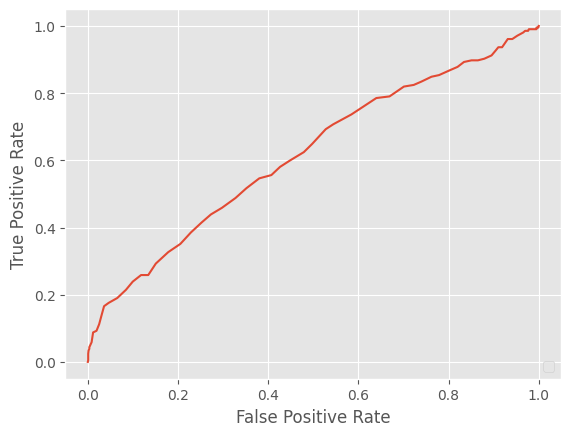

In [14]:
plot_roc(fpr, tpr)

In [17]:
N = 100
ecdf_tpr_true = ecdf(y_pred[y_test == 1], N)
ecdf_fpr_true = ecdf(y_pred[y_test != 1], N)

tpr_true = np.r_[0, ecdf_tpr_true / ecdf_tpr_true.max(), 1]
fpr_true = np.r_[0, ecdf_fpr_true / ecdf_fpr_true.max(), 1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


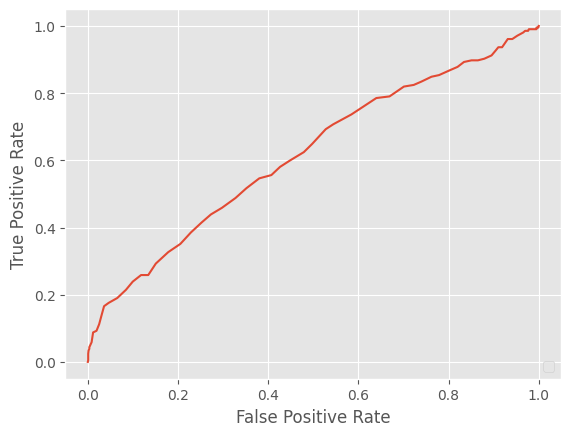

In [18]:
plot_roc(fpr_true, tpr_true)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


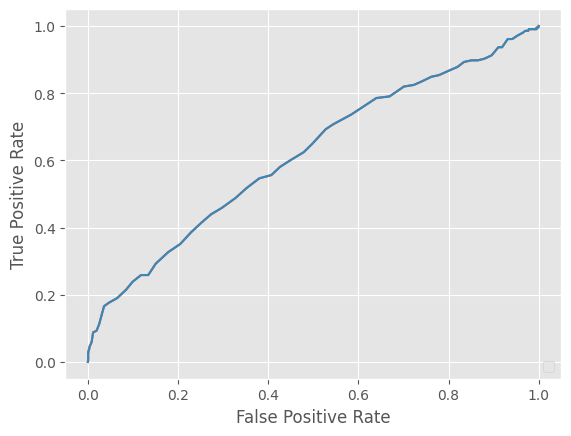

In [19]:
fig, ax = plt.subplots()

xlabel = "False Positive Rate"
ylabel = "True Positive Rate"
ax.set(xlabel=xlabel, ylabel=ylabel)

ax.legend(loc="lower right")

ax.plot(fpr, tpr)
ax.plot(fpr_true, tpr_true)
plt.show()

In [20]:
def geo_score(x_f,
              y_f,
              x_g,
              y_g):
    """
    geo_score: ?
    :param x_f: array
        x coordinates of the f line to draw
    :param y_f: array
        y coordinates of the f line to draw
    :param x_g: array
        x coordinates of the g line to draw, g has same length as f
    :param y_g: array
        y coordinates of the g line to draw, g has same length as f

    :return float geo_score:
        sum of areas between f and g
    """
    idx = np.argwhere(np.diff(np.sign(y_f - y_g))).flatten()
    # make sure we get the last area
    idx = np.r_[idx, len(x_f)-1]
    # compute the difference of areas between each interception
    geo_score = 0
    for i, j in list(zip(idx[:-1], idx[1:])):
        area_f = np.trapz(y_f[i:j+1], x_f[i:j+1])
        area_g = np.trapz(y_g[i:j+1], x_g[i:j+1])
        geo_score += abs(area_f - area_g)
    return geo_score

In [21]:
np.trapz(fpr_true, tpr_true)

0.38347836744699104

In [68]:
y_pred[0]

-0.6474871914781568

In [22]:
geo_score(fpr, tpr, fpr_true, tpr_true)

0

In [124]:
def transform_eval_input(data, precision=10**6):
    if data.min() < 0:
        data = data - data.min()
    return data * N / data.max()

test = transform_eval_input(y_pred)

In [131]:
ecdf_tpr = ecdf(test[y_test == 1], N)
ecdf_fpr = ecdf(test[y_test != 1], N)

tpr_trans = np.r_[0, ecdf_tpr / ecdf_tpr.max(), 1]
fpr_trans = np.r_[0, ecdf_fpr / ecdf_fpr.max(), 1]

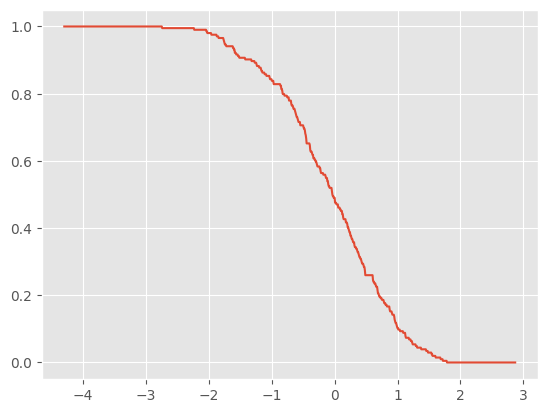

In [136]:
plt.plot((np.arange(N) * (y_pred.max() - y_pred.min()) / (N) + y_pred.min())[::-1], tpr_trans[1:-1])

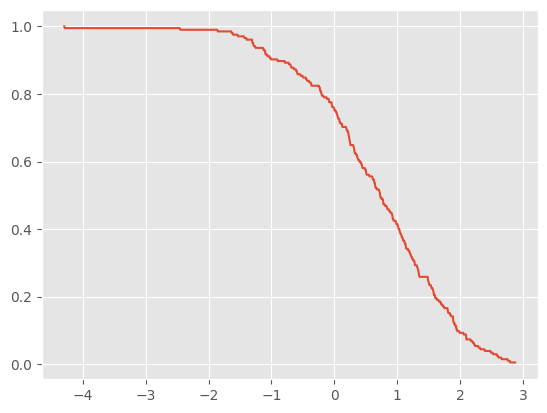

In [152]:
plt.plot(np.linspace(y_pred.min(), y_pred.max(), N)[::-1], tpr_trans_true[1:-1])

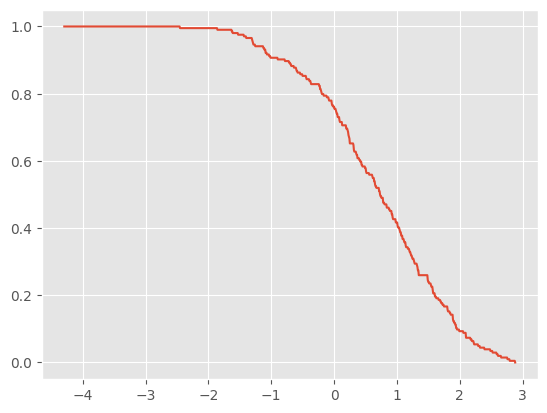

In [137]:
plt.plot(((np.arange(N+2) * (y_pred.max() - y_pred.min()) / (N)) + y_pred.min())[::-1], tpr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


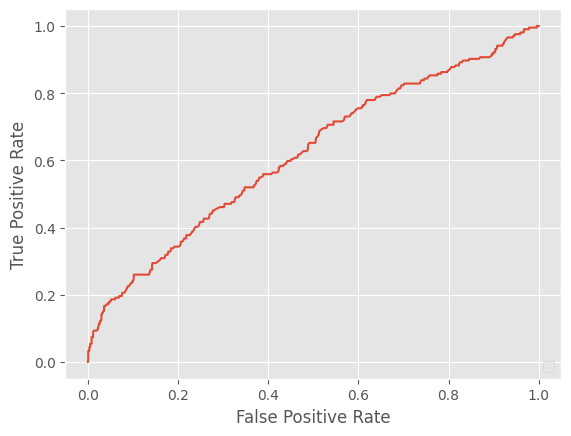

In [116]:
plot_roc(fpr, tpr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


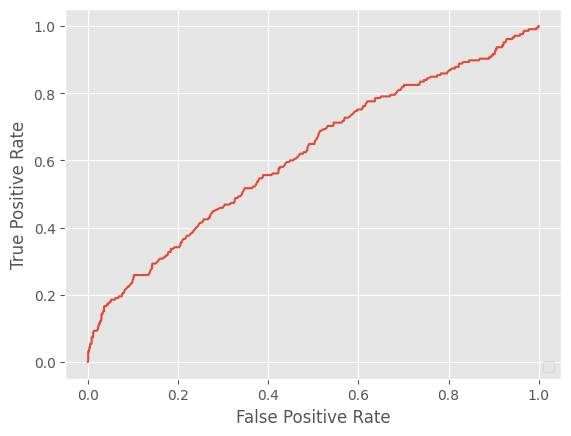

In [153]:
plot_roc(fpr_trans_true, tpr_trans_true)

In [154]:
geo_score(fpr, tpr, fpr_trans_true, tpr_trans_true)

0.054539231266892786

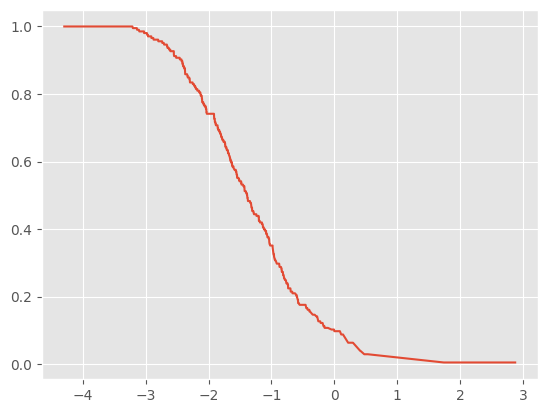

In [117]:
plt.plot(thresholds, tpr_base)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


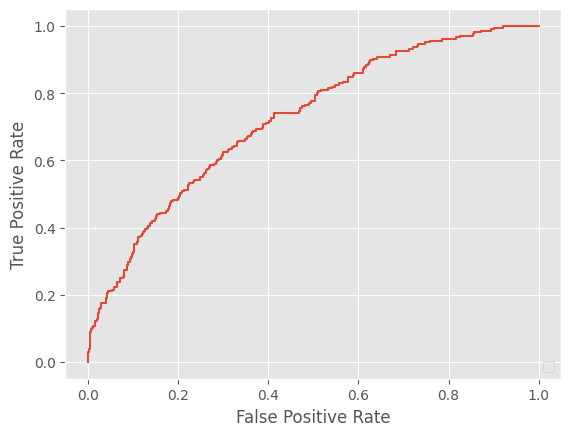

In [94]:
plot_roc(fpr_base, tpr_base)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


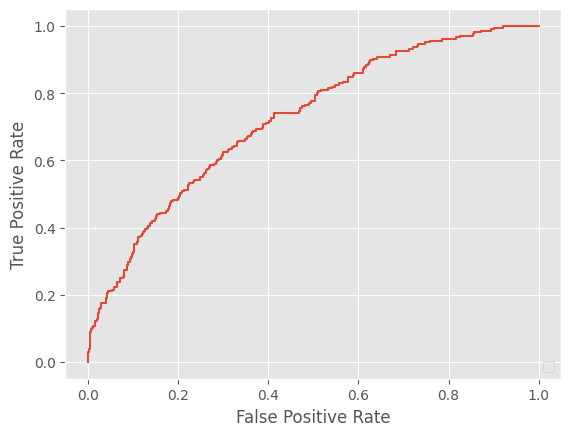

In [50]:
from sklearn import metrics
fpr_base, tpr_base, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
plot_roc(fpr_base, tpr_base)

In [77]:
sample_idx = np.random.choice(np.arange(len(tpr)), len(thresholds)-2, replace=False)

fpr_sample = np.r_[0, fpr[sample_idx], 1]
tpr_sample = np.r_[0, tpr[sample_idx], 1]

ValueError: Cannot take a larger sample than population when 'replace=False'

In [21]:
def geo_score(x_f,
              y_f,
              x_g,
              y_g):
    """
    geo_score: ?
    :param x_f: array
        x coordinates of the f line to draw
    :param y_f: array
        y coordinates of the f line to draw
    :param x_g: array
        x coordinates of the g line to draw, g has same length as f
    :param y_g: array
        y coordinates of the g line to draw, g has same length as f

    :return float geo_score:
        sum of areas between f and g
    """
    idx = np.argwhere(np.diff(np.sign(y_f - y_g))).flatten()
    # make sure we get the last area
    idx = np.r_[idx, len(x_f)-1]
    # compute the difference of areas between each interception
    geo_score = 0
    for i, j in list(zip(idx[:-1], idx[1:])):
        area_f = np.trapz(y_f[i:j+1], x_f[i:j+1])
        area_g = np.trapz(y_g[i:j+1], x_g[i:j+1])
        geo_score += abs(area_f - area_g)
    return geo_score

In [73]:
geo_score(fpr_sample, tpr_sample, fpr_base, tpr_base)

55.77069011183007

In [35]:
results_data = experiment(p = p,do = do, N = N , q = q, l = l, data = y_pred_shift)

In [36]:
results_data['output']

array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
       2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
       2.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 4.000e+00,
       4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00,
       4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00, 4.000e+00,
       4.000e+00, 4.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 6.000e+00,
       6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 6.000e+00, 7.000e+00,
       7.000e+00, 9.000e+00, 1.000e+01, 1.000e+01, 1.000e+01, 1.000e+01,
       1.000e+01, 1.000e+01, 1.000e+01, 1.000e+01, 

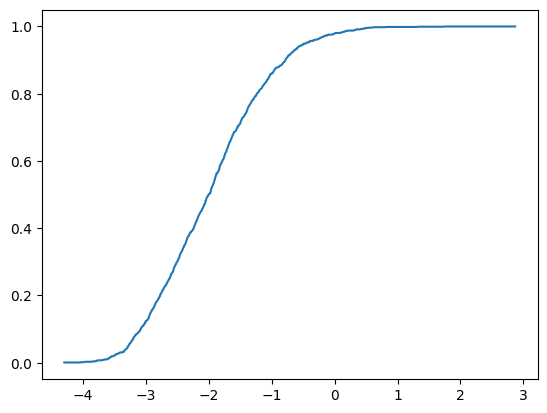

In [44]:
plt.plot(np.arange(N) / (N / (y_pred + abs(y_pred.min())).max()) - abs(y_pred.min()), results_data['output'] / results_data['output'].max())

In [27]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    xlabel = "False Positive Rate"
    ylabel = "True Positive Rate"
    ax.set(xlabel=xlabel, ylabel=ylabel)

    ax.legend(loc="lower right")

    ax.plot(fpr, tpr)
    plt.show()

In [43]:
results_data = experiment(p = p,do = do, N = N , q = q, l = l, data = data)

In [44]:
len(data)

16384

In [45]:
results_data['output']

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

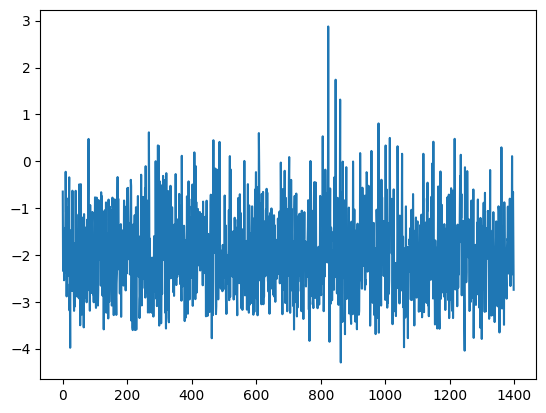

In [41]:
plt.plot(y_pred)

In [34]:
len(results['output'])

1000

In [35]:
len(y_pred)

1399

In [30]:
y_pred[1398]

-2.7437325143166866

In [47]:
l

10

In [48]:
results = experiment(p = p,do = do, N = 100 , q = q, l = l, data = y_pred)

# We can output only the results we are needing
#plot_histograms_and_ecdf(results['output'], N)

In [49]:
results['output']

array([1368., 1396., 1398., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399., 1399.,
       1399.])

## Problems :

No problem for now